# MIR Project: melody segmentation
Prepared by Philip Tovstogan

This project evaluates the performance of two melody segmentation algorithms:

### Local Boundary Detection Model (LBDM) by Cambouropoulos ([MATLAB code](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/boundary.m))

*Cambouropoulos, E. (1997). Musical rhythm: A formal model for determining local boundaries, accents and metre in a melodic surface. In M. Leman (Ed.), Music, Gestalt, and Computing: Studies in Cognitive and Systematic Musicology (pp. 277-293). Berlin: Springer Verlag.*


### Segmentation algorithm by Tenney & Polansky ([MATLAB code](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/segmentgestalt.m))

*Tenney, J.  & Polansky, L. (1980). Temporal gestalt perception in music. Journal of Music Theory, 24(2), 205–41.*

The dataset that is used for evaluation is [SymbTr](https://github.com/MTG/makam-symbolic-phrase-segmentation) that is a collection of Turkish Makam music with ground-truth annotations for phrase boundaries.

In [1]:
import music21 as m21
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [221]:
def lbdm(midi_data):
    """Implementing LBDM as in Miditoolbox (boundary.m)"""
    note_midi = np.array([note.pitch.midi for note in midi_data.recurse().notes])
    pitch_profile = np.abs(note_midi[1:] - note_midi[:-1])  # Miditoolbox variable 'pp'
    
    onsets = []  # Miditoolbox variable 'on'
    offsets_org = []
    durations = []
    
    print(midi_data.timeSignature)
    for note in midi_data.recurse().notes:
        if type(note) is m21.note.Note:  # avoid data without duration, not a note event
            onsets.append(note.offset)
            durations.append(note.duration.quarterLength)
            offsets_org.append(note.offset)
    
    onsets = np.array(onsets)
    durations = np.array(durations)
    offsets = onsets + durations  # Miditoolbox variable 'off'

    ioi_profile = onsets[1:] - onsets[:-1]  # Miditoolbox variable 'po'
    rest_profile = onsets[1:] - offsets[:-1]  # Miditoolbox variable 'pr'
    rest_profile = (rest_profile + np.abs(rest_profile)) / 2  # half wave rect. (max(0,x) in Miditoolbox)

    # degrees of change [see boundary.m]
    rp = np.abs(pitch_profile[1:] - pitch_profile[:-1]) / (0.000001 + pitch_profile[1:] + pitch_profile[:-1])
    rp = np.append(rp,0)
    ro = [np.abs(ioi_profile[1:] - ioi_profile[:-1]) / (0.000001 + ioi_profile[1:] + ioi_profile[:-1])]
    ro = np.append(ro,0)
    rr = [np.abs(rest_profile[1:] - rest_profile[:-1]) / (0.000001 + rest_profile[1:] + rest_profile[:-1])]
    rr = np.append(rr,0)

    # strengths
    sp = pitch_profile * np.append(0, rp[:-1] + rp[1:])
    if np.max(sp) > 0.1:
        sp = sp / np.max(sp)

    so = ioi_profile*np.append(0, ro[:-1] + ro[1:])
    if np.max(so) > 0.1:
        so = so / np.max(so)

    sr = rest_profile * np.append(0, rr[:-1] + rr[1:])
    if np.max(sr) > 0.1:
        sr = sr / np.max(sr)

    # overall profile
    return np.array(onsets), np.append(1, 0.25*sp + 0.5*so + 0.25*sr)

In [203]:
test_filename = 'hicaz--sarki--aksak--su_karsiki--dede_efendi'
# test_filename = 'mahur--sarki--sofyan--ne_dogan--munir_nurettin_selcuk'
# test_filename = 'hicaz--sarki--aksak--su_karsiki_dagda--dede_efendi'
midi_data = m21.converter.parse('midi/{}.mid'.format(test_filename))

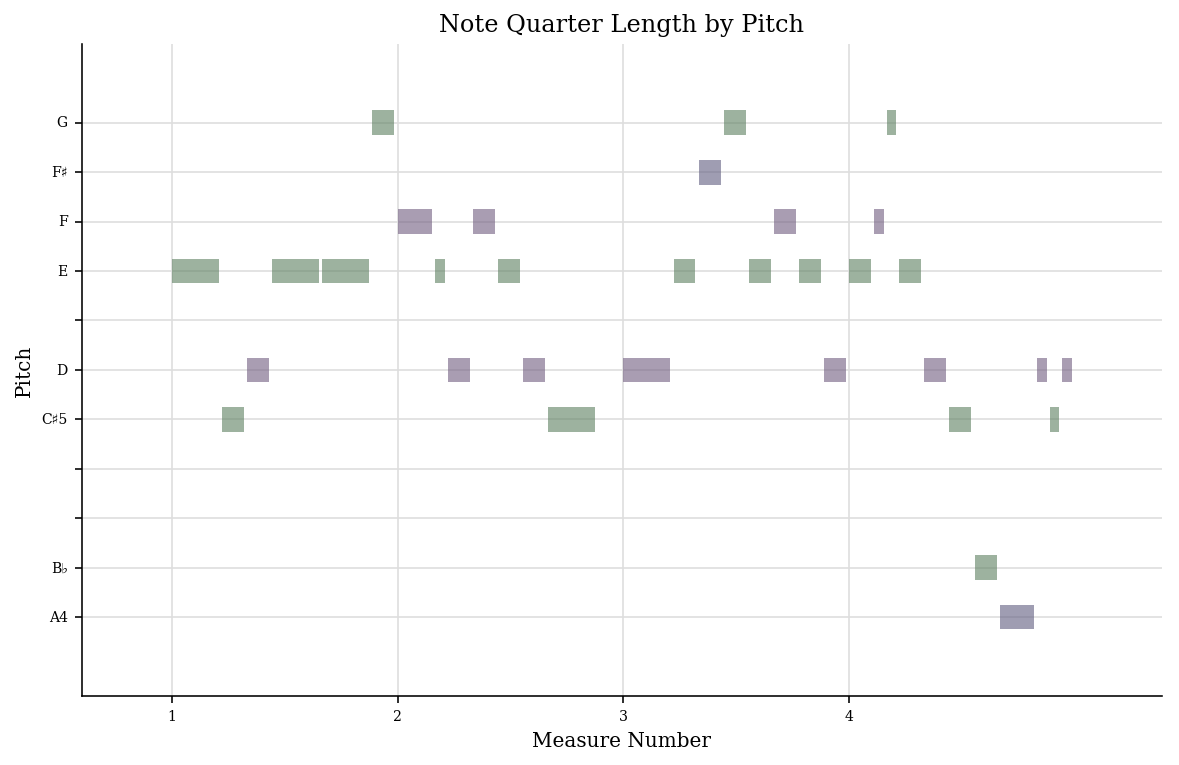

In [215]:
# test_data = midi_data.measures(1, 4)
test_data = midi_data
test_data.measures(0, 4).plot()

In [38]:
count = 0
for item in midi_data[0]:
    print type(item)
    if type(item) is m21.note.Note:
        count += 1
print(len(midi_data[0]), count)

<class 'music21.tempo.MetronomeMark'>
<class 'music21.meter.TimeSignature'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Rest'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>
<class 'music21.note.Note'>


In [222]:
onsets, profile = lbdm(test_data)

None


Text(0.5,0,'Time in quarter lengths')

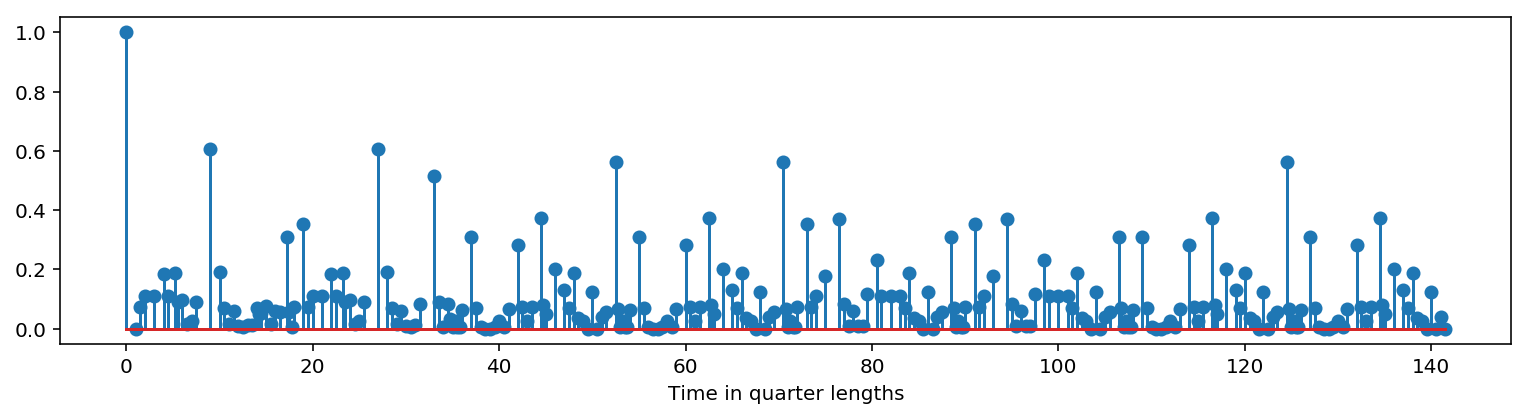

In [206]:
plt.figure(figsize=(13, 3))
plt.stem(onsets, profile)
plt.xlabel('Time in quarter lengths')

In [168]:
len(profile)

259

In [81]:
len(mapping)

258

## Reading ground truth

In [11]:
from symbtrdataextractor.dataextractor import DataExtractor

In [12]:
extractor = DataExtractor()

In [207]:
txt_filename = 'txt/{}.txt'.format(test_filename)
txt_data, is_data_valid = extractor.extract(txt_filename)

In [208]:
with open(txt_filename) as fp:
    raw_txt = fp.readlines()

In [202]:
txt_data

{'composer': {'symbtr_slug': 'munir_nurettin_selcuk'},
 'duration': {'unit': 'second', 'value': 136.674},
 'form': {'attribute_key': u'sarki', 'symbtr_slug': 'sarki'},
 'lyricist': {},
 'makam': {'attribute_key': u'mahur', 'symbtr_slug': 'mahur'},
 'name': {},
 'number_of_notes': 280,
 'phrase_annotations': [],
 'rhythmic_structure': [{'endNote': 280,
   'startNote': 1,
   'tempo': {'unit': 'bpm', 'value': 288},
   'usul': {'attribute_key': u'sofyan',
    'mertebe': 4,
    'mu2_name': u'Sofyan',
    'number_of_pulses': 4,
    'symbtr_internal_id': 6}}],
 'sections': [{'end_note': 55,
   'lyrics': '',
   'lyrics_similarities': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'lyrics_structure': 'INSTRUMENTAL',
   'melodic_similarities': [1.0,
    0.203125,
    0.1875,
    0.12109375,
    0.265625,
    0.359375],
   'melodic_structure': u'A1',
   'name': u'ARANA\u011eME',
   'slug': u'ARANAGME',
   'start_note': 2},
  {'end_note': 94,
   'lyrics': u'Ne do\u011fan g\xfcne h\xfckm\xfcm ge\xe7er ne halde

In [223]:
section_notes = [section['start_note'] for section in txt_data['sections']]
print(section_notes)
section_offsets = [raw_txt[note].split()[-1] for note in section_notes]
section_offsets = np.array(section_offsets, dtype=float)
# section_offsets -= section_offsets[0]
print(section_offsets)

[2, 35, 67, 101, 135, 166, 197, 231]
[ 0.22222222  4.22222222  8.22222222 12.22222222 16.22222222 20.22222222
 24.22222222 28.22222222]


Text(0.5,0,'Time in quarter lengths')

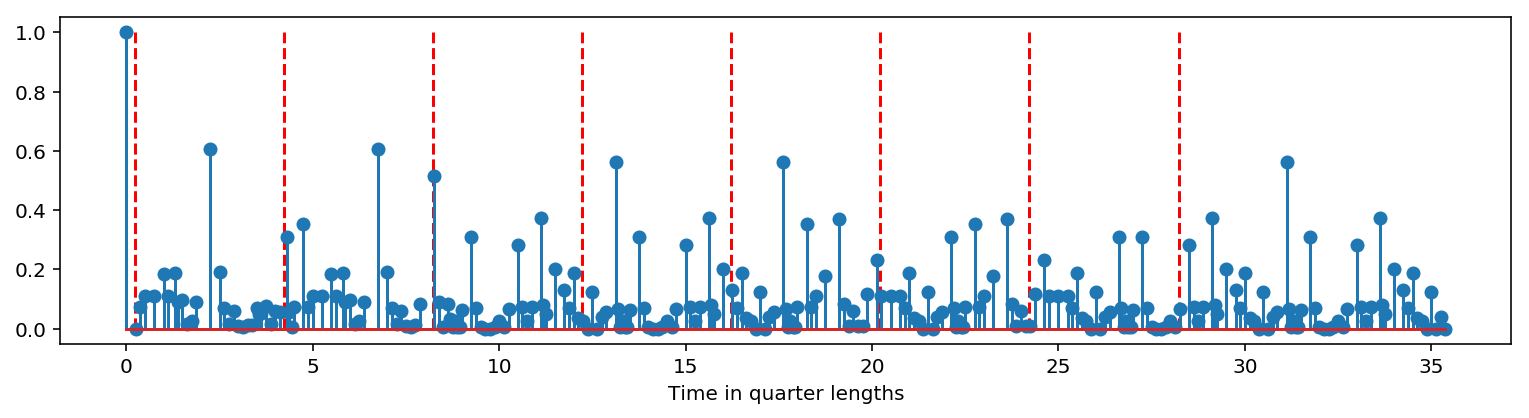

In [214]:
plt.figure(figsize=(13, 3))
plt.stem(onsets / 4, profile)
plt.vlines(section_offsets, 0, 1, 'r', linestyles='dashed')
plt.xlabel('Time in quarter lengths')


Text(0.5,0,'Time in quarter lengths')

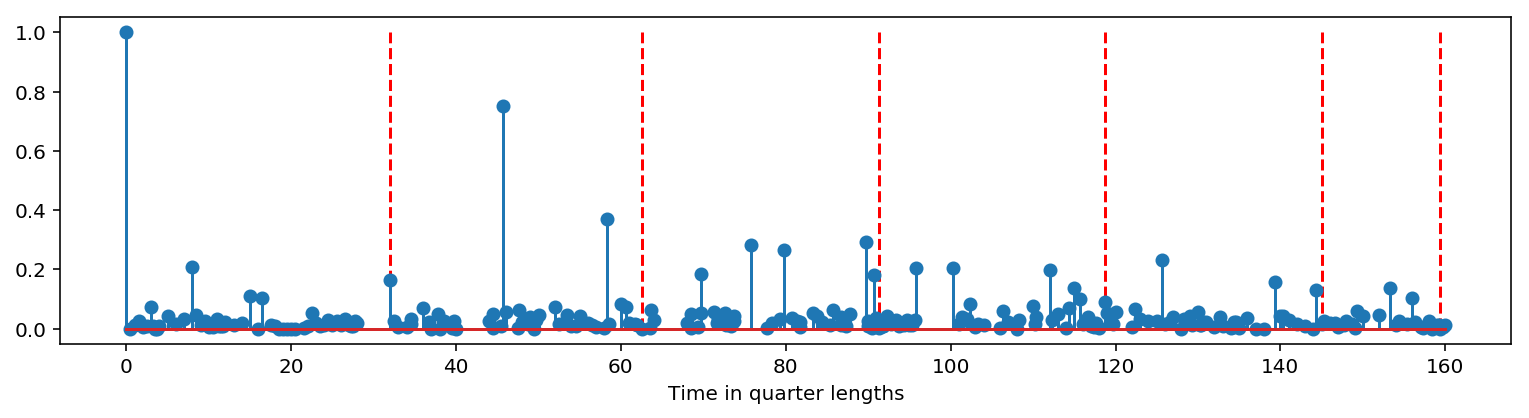

In [200]:
plt.figure(figsize=(13, 3))
plt.stem(onsets, profile)
plt.vlines(onsets[mapping[annotated_sections]], 0, 1, 'r', linestyles='dashed')
# plt.stem(cum_durations[mapping[annotated_sections]], np.ones_like(annotated_sections), 'r')
plt.xlabel('Time in quarter lengths')


In [216]:
onsets

array([  0.  ,   1.  ,   1.5 ,   2.  ,   3.  ,   4.  ,   4.5 ,   5.25,
         5.5 ,   6.  ,   6.5 ,   7.  ,   7.5 ,   9.  ,  10.  ,  10.5 ,
        11.  ,  11.5 ,  12.  ,  12.5 ,  13.  ,  13.5 ,  14.  ,  14.25,
        14.5 ,  15.  ,  15.5 ,  16.  ,  16.5 ,  17.25,  17.5 ,  17.75,
        18.  ,  19.  ,  19.5 ,  20.  ,  21.  ,  22.  ,  22.5 ,  23.25,
        23.5 ,  24.  ,  24.5 ,  25.  ,  25.5 ,  27.  ,  28.  ,  28.5 ,
        29.  ,  29.5 ,  30.  ,  30.5 ,  31.  ,  31.5 ,  33.  ,  33.5 ,
        34.  ,  34.5 ,  34.75,  35.  ,  35.25,  35.5 ,  35.75,  36.  ,
        37.  ,  37.5 ,  38.  ,  38.5 ,  39.  ,  39.5 ,  40.  ,  40.5 ,
        41.  ,  42.  ,  42.5 ,  43.  ,  43.5 ,  44.5 ,  44.75,  45.  ,
        46.  ,  47.  ,  47.5 ,  48.  ,  48.5 ,  49.  ,  49.5 ,  50.  ,
        50.5 ,  51.  ,  51.5 ,  52.5 ,  52.75,  53.  ,  53.25,  53.5 ,
        53.75,  54.  ,  55.  ,  55.5 ,  56.  ,  56.5 ,  57.  ,  57.5 ,
        58.  ,  58.5 ,  59.  ,  60.  ,  60.5 ,  61.  ,  61.5 ,  62.5 ,
      

In [132]:
cum_durations

array([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.5, 4.5,
       5.5, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0,
       10.0, 11.0, 12.0, 13.0, 13.5, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0,
       17.5, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.25, 21.5, 21.75, 22.0,
       22.25, 22.5, 22.75, 23.0, 23.25, 23.5, 27.25, 27.75, 28.25, 29.25,
       29.583333333333332, 29.583333333333332, 31.083333333333332,
       31.833333333333332, 32.08333333333333, 32.83333333333333,
       33.08333333333333, 33.58333333333333, 34.58333333333333,
       34.83333333333333, 35.08333333333333, 38.83333333333333,
       39.33333333333333, 39.33333333333333, 40.08333333333333,
       40.33333333333333, 41.83333333333333, 42.08333333333333,
       42.83333333333333, 43.33333333333333, 43.58333333333333,
       45.58333333333333, 46.08333333333333, 47.08333333333333,
       47.58333333333333, 48.08333333333333, 48.58333333333333,
       49.58333333333333, 50.08333333333333, 50.583